In [1]:
import os
import clr
import sys
from imp import reload
from System import Array
from time import sleep
import numpy as np
from matplotlib import pyplot as plt
# sys.path.append(os.getcwd())
%matplotlib inline

In [27]:
import qcodes.instrument_drivers.AlazarTech.ATS9440 as ATS_driver
import qcodes.instrument_drivers.AlazarTech.ATS_acquisition_controllers as ATS_control
try:
    ATS.close()
    ATS_controller.close()
except:
    pass
reload(ATS_driver)
reload(ATS_control)

ATS = ATS_driver.ATS9440('ATS', server_name='Alazar_server')
ATS_controller = ATS_control.Average_AcquisitionController(name='ATS_control', 
                                                           alazar_id=0,
                                                           server_name='Alazar_server')

ATS.config(trigger_source1='CHANNEL_C',
           trigger_level1=135,
           channel_range=[2,2],
           sample_rate=5e6,
           coupling=['DC','DC'])
ATS_controller.set_acquisitionkwargs(buffer_timeout=5000,
                                     samples_per_record=200000,
                                     records_per_buffer=2,
                                     buffers_per_acquisition=1)


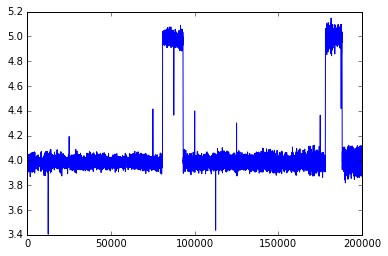

In [28]:
result = ATS_controller.do_acquisition()

# plt.plot(result[0])
plt.plot(result[1])